## Visual Geometry Group Models (VGG16 & VGG19)
Documentation to be filled up later BLABLABLA

### Installation and Import Checks

In [53]:
%pip install tensorflow==2.10
%pip install scikit-learn
%pip install matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [54]:
import numpy as np
# Machine Learning
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# Plotting
import matplotlib.pyplot as plt

### Optional: GPU Acceleration Check
Checks Tensorflow Version and GPU detection. 
If GPU detected, output should be something like "Num GPUs Available:  1"

In [55]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices()
print("Physical Devices:", physical_devices)

TensorFlow version: 2.10.0
Num GPUs Available:  1
Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load and Split Prepared Data
Loads in preprocessed data from the ./prepared_data directory for x and y features. Splits for training and testing 80/20 ratio

In [56]:
# Load the data
x_input = np.load('prepared_data/x_input_combined.npy')
y_output = np.load('prepared_data/y_output_combined.npy')

# Ensure y is one-hot encoded if not already
y_output = to_categorical(y_output, num_classes=4)  # Assuming there are 4 classes

# Split the data into training and testing sets
x_input_train, x_input_test, y_output_train, y_output_test = train_test_split(x_input, y_output, test_size=0.2, random_state=42)

# Printing Dimensions of data
print(f'X Training Data\nNumber of Rows: {x_input_train.shape[0]}\nPixel Dimensions: {x_input_train.shape[1]}x{x_input_train.shape[2]}x{x_input_train.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_train.shape[0]}\nNumber of Classes: {y_output_train.shape[1]}\n')
print(f'X Testing Data\nNumber of Rows: {x_input_test.shape[0]}\nPixel Dimensions: {x_input_test.shape[1]}x{x_input_test.shape[2]}x{x_input_test.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_test.shape[0]}\nNumber of Classes: {y_output_test.shape[1]}')

X Training Data
Number of Rows: 1536
Pixel Dimensions: 128x128x3

Y Training Data
Number of Rows: 1536
Number of Classes: 4

X Testing Data
Number of Rows: 384
Pixel Dimensions: 128x128x3

Y Training Data
Number of Rows: 384
Number of Classes: 4


### Loading and Defining VGG16 & VGG19 Model
In this step, we define our base model by call the pretrained VGG models from Tensorflow. The model is loaded with the weightages trained from the ImageNet dataset and we define the inputs dimensions that model should expect. We also remove the top output layer such that we can add it on later. These layers are our base models that will not be changed. 
* weights='imagenet' > Loads weightages from ImageNet data training
* include_top = False > Exclude top layers of model, to add custom top layers (tuning with our data)
* input_shape > Specify the dimensions of our input data, which is given as 128 x 128 pixels and 3 representing color channels in each image (RGB)

More layers are defined below which will be trained and used for the tuning of the model using the brain MRI imagery data we provide. 

In [57]:
# Load the VGG16 model pre-trained on ImageNet
base_vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Adds global average pooling layer to reduce dimensions of features                     
pooled_layer_vgg16 = GlobalAveragePooling2D()(base_vgg16_model.output)
# Adds a dense lyaer with 1024 neurons using RELU activation function                
dense_layer_vgg16 = Dense(1024, activation='relu')(pooled_layer_vgg16)
# Add dropout layer with 50% dropout rate for regularization to avoid overfitting                       
dropout_layer_vgg16 = Dropout(0.5)(dense_layer_vgg16)                                         
# Add final output layer with four neurons corresponding to four classes with activation as softmax to predict probability of each class
new_output_layer_vgg16 = Dense(4, activation='softmax')(dropout_layer_vgg16) 

# Define the model
vgg16_brain_tumor_model = Model(inputs=base_vgg16_model.input, outputs=new_output_layer_vgg16)

# Freeze the layers of the base model
for layer in base_vgg16_model.layers:
    layer.trainable = False

In [58]:
# Load the VGG19 model pre-trained on ImageNet
base_vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Adds global average pooling layer to reduce dimensions of features                     
pooled_layer_vgg19 = GlobalAveragePooling2D()(base_vgg19_model.output)
# Adds a dense lyaer with 1024 neurons using RELU activation function                
dense_layer_vgg19 = Dense(1024, activation='relu')(pooled_layer_vgg19)
# Add dropout layer with 50% dropout rate for regularization to avoid overfitting                       
dropout_layer_vgg19 = Dropout(0.5)(dense_layer_vgg19)                                         
# Add final output layer with four neurons corresponding to four classes with activation as softmax to predict probability of each class
new_output_layer_vgg19 = Dense(4, activation='softmax')(dropout_layer_vgg19) 

# Define the model
vgg19_brain_tumor_model = Model(inputs=base_vgg19_model.input, outputs=new_output_layer_vgg19)

# Freeze the layers of the base model
for layer in base_vgg19_model.layers:
    layer.trainable = False

### Training the VGG16 & VGG19 Models


In [59]:
# Compile the model
vgg16_brain_tumor_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_vgg16 = ModelCheckpoint('model_checkpoints/vgg16_brain_tumor.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_vgg16 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
trained_vgg16_model = vgg16_brain_tumor_model.fit(x_input_train, y_output_train, epochs=50, validation_data=(x_input_test, y_output_test), 
                    callbacks=[checkpoint_vgg16, early_stopping_vgg16])

Epoch 1/50
46/48 [===========================>..] - ETA: 0s - loss: 1.0690 - accuracy: 0.5319
Epoch 1: val_loss improved from inf to 0.78023, saving model to model_checkpoints\vgg16_brain_tumor.keras
48/48 [==============================] - 2s 34ms/step - loss: 1.0588 - accuracy: 0.5345 - val_loss: 0.7802 - val_accuracy: 0.7031
Epoch 2/50
46/48 [===========================>..] - ETA: 0s - loss: 0.7481 - accuracy: 0.7052
Epoch 2: val_loss improved from 0.78023 to 0.64308, saving model to model_checkpoints\vgg16_brain_tumor.keras
48/48 [==============================] - 1s 28ms/step - loss: 0.7513 - accuracy: 0.7038 - val_loss: 0.6431 - val_accuracy: 0.7656
Epoch 3/50
46/48 [===========================>..] - ETA: 0s - loss: 0.6308 - accuracy: 0.7575
Epoch 3: val_loss did not improve from 0.64308
48/48 [==============================] - 1s 26ms/step - loss: 0.6295 - accuracy: 0.7617 - val_loss: 0.6585 - val_accuracy: 0.7318
Epoch 4/50
46/48 [===========================>..] - ETA: 0s - los

In [60]:
# Compile the model
vgg19_brain_tumor_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_vgg19 = ModelCheckpoint('/model_checkpoints/vgg19_brain_tumor.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_vgg19 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
trained_vgg19_model = vgg19_brain_tumor_model.fit(x_input_train, y_output_train, epochs=50, validation_data=(x_input_test, y_output_test), 
                    callbacks=[checkpoint_vgg19, early_stopping_vgg19])

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 1.1376 - accuracy: 0.5033
Epoch 1: val_loss improved from inf to 0.91850, saving model to /model_checkpoints\vgg19_brain_tumor.keras
48/48 [==============================] - 2s 36ms/step - loss: 1.1376 - accuracy: 0.5033 - val_loss: 0.9185 - val_accuracy: 0.5911
Epoch 2/50
46/48 [===========================>..] - ETA: 0s - loss: 0.8609 - accuracy: 0.6488
Epoch 2: val_loss improved from 0.91850 to 0.80173, saving model to /model_checkpoints\vgg19_brain_tumor.keras
48/48 [==============================] - 2s 33ms/step - loss: 0.8598 - accuracy: 0.6497 - val_loss: 0.8017 - val_accuracy: 0.6536
Epoch 3/50
47/48 [============================>.] - ETA: 0s - loss: 0.7988 - accuracy: 0.6822
Epoch 3: val_loss improved from 0.80173 to 0.75214, saving model to /model_checkpoints\vgg19_brain_tumor.keras
48/48 [==============================] - 2s 33ms/step - loss: 0.7957 - accuracy: 0.6829 - val_loss: 0.7521 - val_accuracy: 0.6875

### Plotting VGG Model Performances

In [61]:
def plot_model_performance(history, title):
    """
    Plot training and validation loss and accuracy.

    Parameters:
    - history: Keras History object
    - title: str, title of the plot
    """
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)
    plt.show()

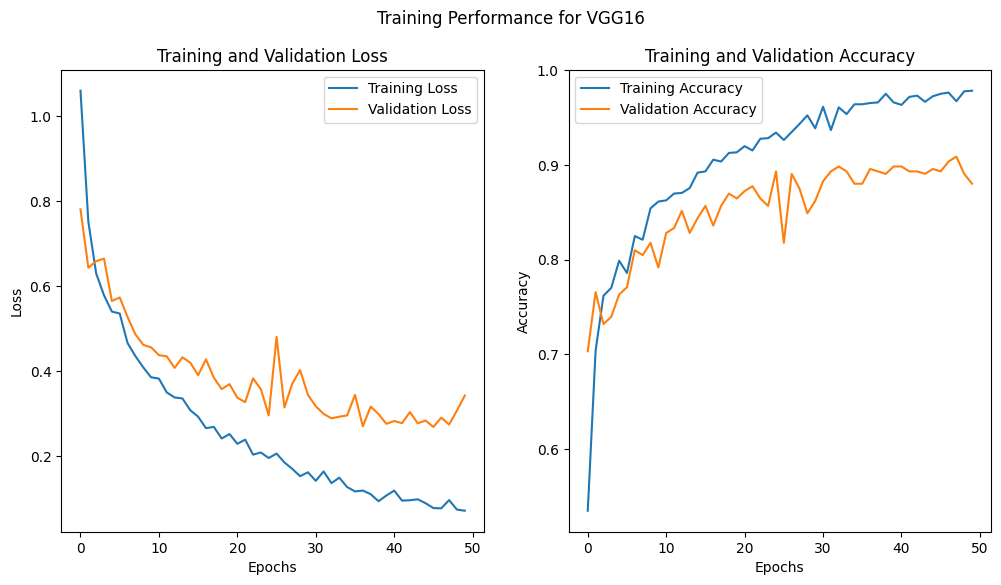

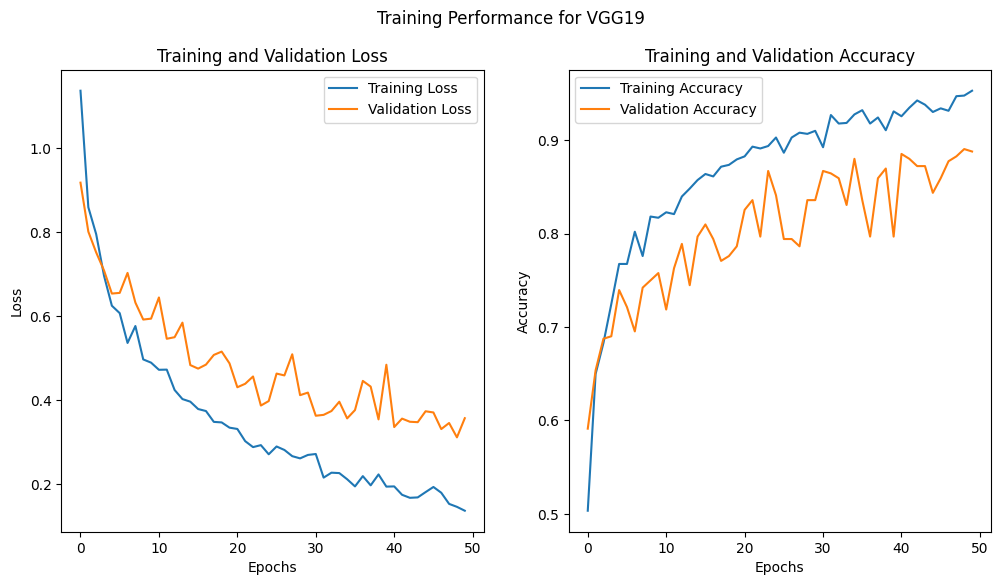

In [62]:
plot_model_performance(trained_vgg16_model, "Training Performance for VGG16")
plot_model_performance(trained_vgg19_model, "Training Performance for VGG19")